# Michaelis-Menten Model Calibration Example


In [1]:
import numpy as np
import roadrunner
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
from pypesto.ensemble import Ensemble
import os 

SEED=12345
np.random.seed(seed=SEED)
engine = eng.SingleCoreEngine()#eng.MultiProcessEngine(n_procs=os.cpu_count())

print(os.cpu_count())

MODEL_SBML_FILE = "model_sbml.xml"
SPECIES = ["S", "E", "ES", "P"]
SPECIES_IDs = ["S1", "S2", "S3", "S4"] # how the species ids are saved in the SBML file from the original BNGL model
SPECIES_COLORS = ["r", "b", "indigo", "g"]
PARAMS = ["log_k1", "log_k2", "log_k3"]

LOG_ERROR = False

8


### Load experimental data used to calibrate model

From here: https://github.com/RuleWorld/ptempest/tree/master/examples/michment


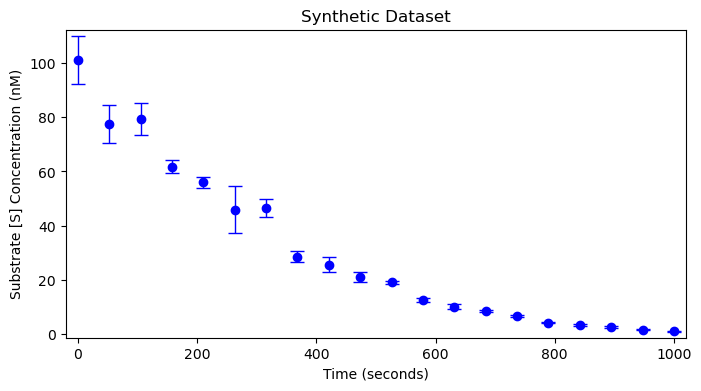

In [2]:
data = io.loadmat("MM.mat")["expt"]
data = data.ravel()[0][0]
data_ts = data["time"][0].flatten()
means = data["mean"][0]
data_means = means[~(pd.isnull(means))]
stds = data["stdev"][0]
data_stds = stds[~(pd.isnull(stds))]
labels = data["obsv_labels"][0][0]
data_labels = [x[0] for x in labels]
init_conds = [data["S0"][0][0][0], data["E0"][0][0][0]]

plt.figure(figsize=(8,4)),
plt.errorbar(data_ts, data_means, yerr=data_stds, capsize=5, c="b", lw=0, marker="o", elinewidth=1);
plt.xlabel("Time (seconds)"); plt.ylabel("Substrate [S] Concentration (nM)");
plt.margins(x=0.02, y=0.02);
plt.title("Synthetic Dataset");

### Load model using `libroadrunner`


In [3]:
rr = roadrunner.RoadRunner(MODEL_SBML_FILE)
rr.integrator.absolute_tolerance = 5e-10
rr.integrator.relative_tolerance = 1e-8
print(rr.model.getGlobalParameterIds())
rr["init([S1])"] = float(init_conds[0]) # change initial substrate concentration
rr["init([S2])"] = float(init_conds[1]) # change initial enzyme concentration

['log_k1', 'log_k2', 'log_k3', 'S', 'E', 'ES', 'P', 'k1', 'k2', 'k3']


### Define helper functions that change model parameters and simulate model


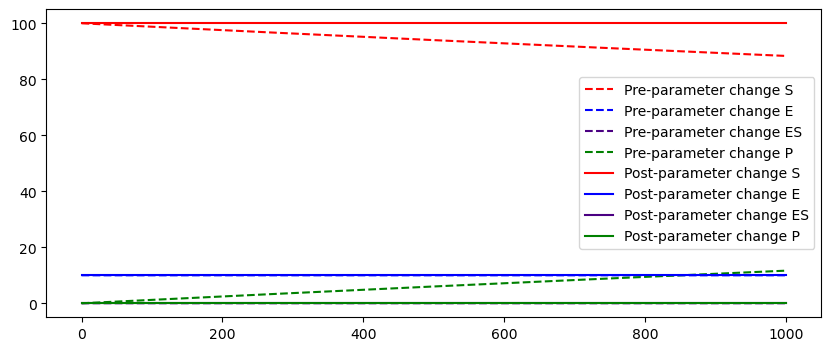

In [4]:
# determine output time points for model based on data time points
step = (len(data_ts)-1)*10
duration = 1000.0

def change_and_run(new_params):
    rr.reset()
    for name,val in zip(PARAMS, new_params):
        #print(name, "PRE-CHANGE IN MODEL: ",  rr[name])
        rr[name] = val
        rr.reset() # This forces assignment rules in the SBML model to be re-evaluated
        #print(name, val, rr[name])
    try:
        res = rr.simulate(0, duration, steps=step)
        #print(res)
    except:
        res = []
    return res

rr.resetAll()
plt.figure(figsize=(10,4))
orig_traj = rr.simulate(0, duration, steps=step)
orig_ts = orig_traj[:, 0]
#print(orig_ts)
orig_specs = np.transpose(orig_traj[:, 1:])
for cur_label, cur_traj, cur_c in zip(SPECIES, orig_specs, SPECIES_COLORS):
    plt.plot(orig_ts, cur_traj, c=cur_c, label="Pre-parameter change %s"%cur_label, linestyle="--")
plt.legend();

# sanity check by setting all parameters to near 0
traj = change_and_run([-10, -10, -10])
traj_ts = traj[:, 0]
traj_specs = np.transpose(traj[:, 1:])

for cur_label, cur_traj, cur_c in zip(SPECIES, traj_specs, SPECIES_COLORS):
    plt.plot(traj_ts, cur_traj, c=cur_c, label="Post-parameter change %s"%cur_label)
plt.legend();

### Define cost function


In [5]:
def cost_fun(params):
    candidate_params = copy.deepcopy(params)    
    guess_res = change_and_run(candidate_params)

    if np.isnan(guess_res).any():
        return np.inf
    
    guess_ts = guess_res[:, 0]
    guess_s = guess_res[:, 1] # substrate 
    #print(guess_ts)
    #print('Data: ', data_ts)
    t_idxs = np.array([i for i in range(len(guess_ts)) for j in range(len(data_ts)) if math.isclose(guess_ts[i],data_ts[j])])
    #print('\n\nT_IDXS: ', t_idxs, '\n', t_idxs.shape[0])
    #print(data_ts.shape[0])
    
    #for g, d in zip(guess_ts, data_ts):
    #print(g, d, g==d, math.isclose(g,d))
    
    if t_idxs.shape[0] != data_ts.shape[0]:
        raise Exception('Not all the times outputted by candidate parameter system are found in data time points! We cannot calculate error!')
    
    guess_s_short = guess_s[t_idxs]
    sse = np.sum(np.square(data_means - guess_s_short) / data_stds)
    
    if LOG_ERROR:
        sse = np.log10(sse)
        
    return sse
    

cost_fun([-1,-1,-1])

7672.917878443158

In [6]:
error = pypesto.Objective(fun=cost_fun)

bnds = np.log10([(1e-5, 1e1), (1e-3, 1e3), (1e-3, 1e3)])
print(bnds)
lb = [x[0] for x in bnds]; ub = [x[1] for x in bnds];
print(ub)
problem = pypesto.Problem(
    objective=error,
    lb=lb,
    ub=ub,
)

[[-5.  1.]
 [-3.  3.]
 [-3.  3.]]
[1.0, 3.0, 3.0]


In [7]:
history_options = pypesto.HistoryOptions(trace_record=True)
optim_nm = optimize.ScipyOptimizer(
    method='Powell', 
    options={'maxiter':int(1e4)}
)

bnd_result = optimize.minimize(
    problem=problem,
    optimizer=optim_nm,
    n_starts=1,
    filename=None, engine=engine,
    progress_bar=True, history_options=history_options
)

100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

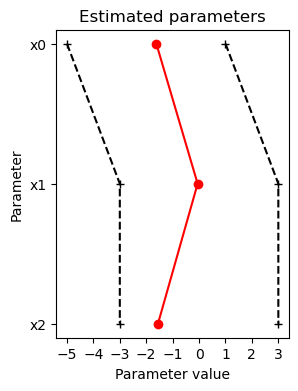

In [8]:
visualize.parameters(bnd_result, size=(3,4))

In [ ]:
n_samps = 500000
sampler = sample.ParallelTemperingSampler(internal_sampler=sample.MetropolisSampler(), n_chains=3)
bnd_result = sample.sample(
    problem=problem, 
    n_samples=n_samps, 
    result=bnd_result, 
    sampler=sampler,
    filename=None
)
elapsed_time = bnd_result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

print(bnd_result.sample_result.keys())
print(bnd_result.sample_result['burn_in'])

In [ ]:
store.write_result(bnd_result, 'mm_test.hdf5', overwrite=True, optimize=False, problem=True, sample=True)

In [9]:
results_fn = "mm_test.hdf5"
result = store.read_result(results_fn, problem=True, optimize=False, sample=True)


This problem is not to be used without a separately created objective.


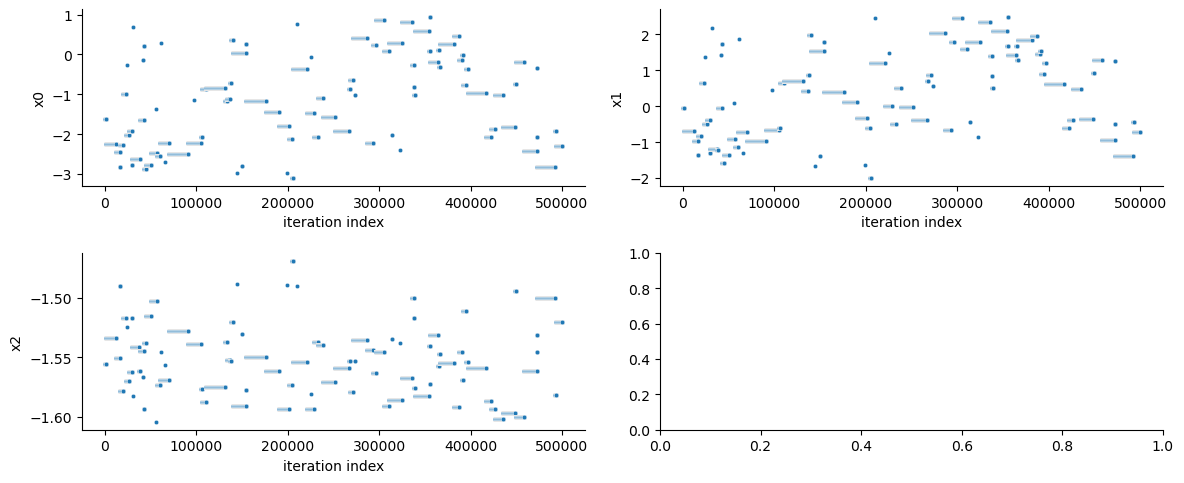

In [10]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)

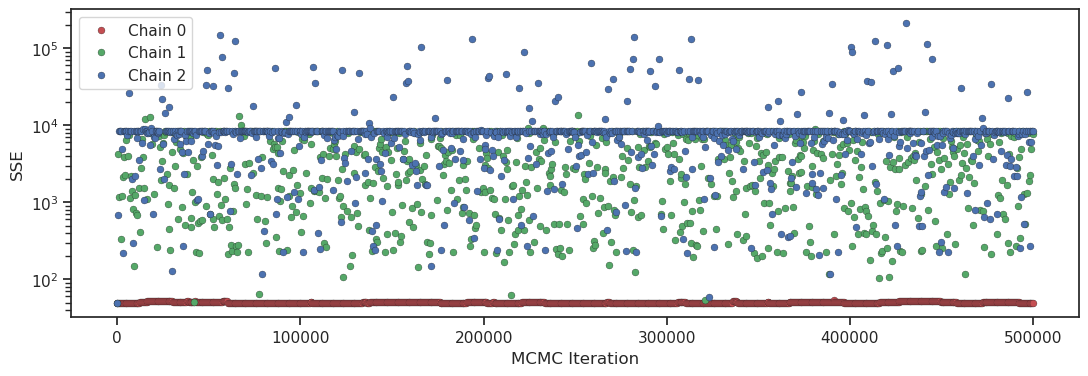

In [11]:
post = result.sample_result['trace_neglogpost']

STEP = 500
plt.figure(figsize=(13,4));
colors = ['r', 'g', 'b']

# iterate through each chain
for i, c, cur_post in zip(np.arange(post.shape[0]), colors, post):
    plt.plot(np.arange(1,len(cur_post)+1)[::STEP], cur_post[::STEP], 'o', markersize=5, color=c, markeredgecolor='k', markeredgewidth=0.2, label="Chain %d"%i)
plt.legend(); plt.yscale('log');
plt.ylabel('SSE'); plt.xlabel('MCMC Iteration');

In [12]:
sample.geweke_test(result=result)

Geweke burn-in index: 200000


200000

In [13]:
time = result.sample_result.time
sample.effective_sample_size(result=result)
ess = result.sample_result.effective_sample_size
print(
    f"Effective sample size per computation time: {round(ess/time,5)}"
)

Estimated chain autocorrelation: 38094.24133274295
Estimated effective sample size: 7.875025580744869


Effective sample size per computation time: 0.00134


In [14]:
# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    x_names=PARAMS,
    remove_burn_in=True,
    lower_bound=lb,
    upper_bound=ub,
)

ensemble.check_identifiability()

,parameterId,lowerBound,upperBound,ensemble_mean,ensemble_std,ensemble_median,within lb: 1 std,within ub: 1 std,within lb: 2 std,within ub: 2 std,within lb: 3 std,within ub: 3 std,within lb: perc 5,within lb: perc 20,within ub: perc 80,within ub: perc 95
parameterId,,,,,,,,,,,,,,,,
log_k1,log_k1,-5.0,1.0,-0.853289,1.149516,-0.853289,True,True,True,False,True,False,True,True,True,True
log_k2,log_k2,-3.0,3.0,0.682608,1.183220,0.682608,True,True,True,False,True,False,True,True,True,True
log_k3,log_k3,-3.0,3.0,-1.560050,0.027967,-1.560050,True,True,True,True,True,True,True,True,True,True


In [15]:
# simple wrapper to calculate predict substrate trajectory given candidate parameter set
def predict(params):
    res = change_and_run(params)
    guess_ts = res[:, 0]
    guess_s = res[:, 1]
    return guess_s

trajs = [predict(x) for x in np.transpose(ensemble.x_vectors)]

In [16]:
trajs = np.array(trajs)
print(trajs.shape)
means = np.mean(trajs, axis=0)
print(means.shape)

(300001, 191)
(191,)


# Calculate confidence intervals using entire ensemble

In [17]:
import scipy.stats as st

ci = 0.95
intervals = np.array(st.norm.interval(alpha=ci, loc=np.mean(trajs, axis=0), scale=np.std(trajs, axis=0)))
print(intervals.shape)

ci2 = 0.9999
intervals2 = np.array(st.norm.interval(alpha=ci2, loc=np.mean(trajs, axis=0), scale=np.std(trajs, axis=0)))

print(intervals[:, 1])
print(intervals2[:, 1])

(2, 191)
[90.42141177 93.79700379]
[88.75887812 95.45953743]


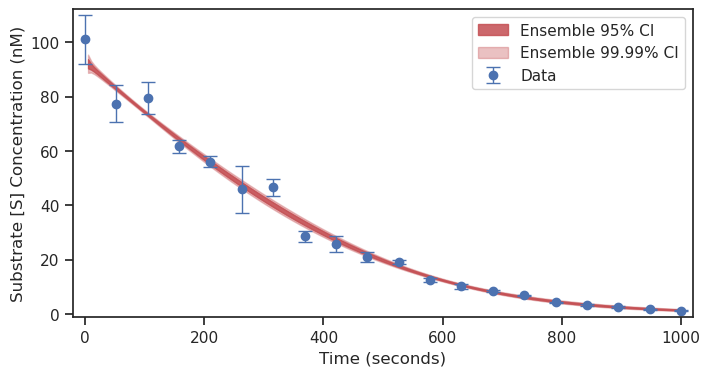

In [24]:
sim_ts = np.linspace(0, duration, num=intervals.shape[1])

plt.figure(figsize=(8,4))

# plot experimental data
plt.errorbar(data_ts, data_means, yerr=data_stds, capsize=5, color="b", alpha=1.0, lw=0, marker="o", elinewidth=1, label='Data');
# plot ensemble predictions
plt.fill_between(sim_ts, intervals[0, :], intervals[1, :], alpha=0.85, color='r', label="Ensemble {pct:n}% CI".format(pct=ci*100))
plt.fill_between(sim_ts, intervals2[0, :], intervals2[1, :], alpha=0.35, color='r', label="Ensemble {pct:n}% CI".format(pct=ci2*100))

plt.xlabel("Time (seconds)"); plt.ylabel("Substrate [S] Concentration (nM)");
plt.margins(x=0.02, y=0.02); plt.legend();

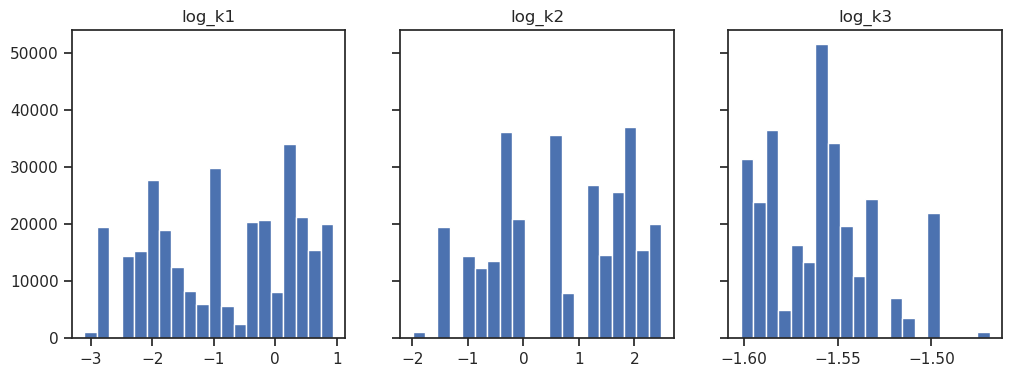

In [25]:
samps = ensemble.x_vectors
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), sharey=True) 

ax1.hist(samps[0, :], bins=20); ax1.set_title(PARAMS[0]);
ax2.hist(samps[1, :], bins=20); ax2.set_title(PARAMS[1]);
ax3.hist(samps[2, :], bins=20); ax3.set_title(PARAMS[2]);

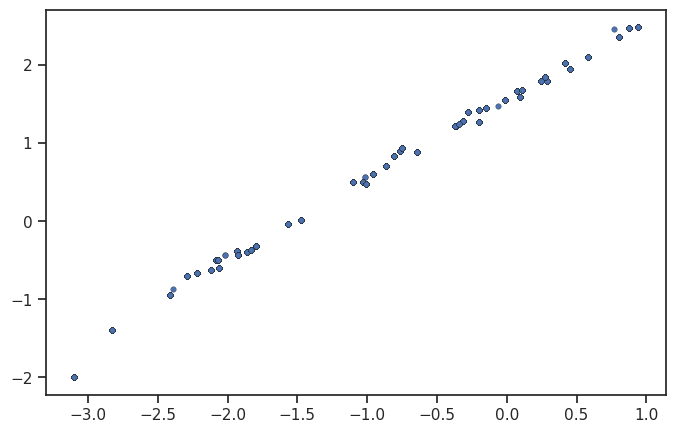

In [27]:
plt.figure(figsize=(8,5), dpi=100)
plt.plot(samps[0, :], samps[1, :], 'bo', markersize=4, markeredgecolor='k', markeredgewidth=0.2);